/usr/local/lib/python3.11/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


=== PRIMA FASE: MODEL SELECTION SU VALIDATION SET ===

==> Addestramento: Logistic Regression

==> Addestramento: k-NN
Iperparametri ottimali: {'metric': 'euclidean', 'n_neighbors': 7}

==> Addestramento: SVM
Iperparametri ottimali: {'C': 10, 'kernel': 'rbf'}

==> Addestramento: Decision Tree
Iperparametri ottimali: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}

=== METRICHE SUL VALIDATION SET ===
Modello              Accuracy   Precision  Recall     F1        
Logistic Regression  0.3687     0.3653     0.3687   0.3650
k-NN                 0.3173     0.3890     0.3173   0.2919
SVM                  0.4467     0.4503     0.4467   0.4472
Decision Tree        0.2627     0.2526     0.2627   0.2455

✅ Miglior modello su validation set: SVM


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:13


=== VALUTAZIONE DEL MODELLO SVM SU TEST SET ===
              precision    recall  f1-score   support

           0       0.50      0.56      0.53       150
           1       0.57      0.61      0.59       150
           2       0.33      0.37      0.35       150
           3       0.28      0.31      0.30       150
           4       0.38      0.35      0.37       150
           5       0.38      0.35      0.36       150
           6       0.52      0.53      0.52       150
           7       0.53      0.46      0.49       150
           8       0.64      0.58      0.61       150
           9       0.58      0.56      0.57       150

    accuracy                           0.47      1500
   macro avg       0.47      0.47      0.47      1500
weighted avg       0.47      0.47      0.47      1500



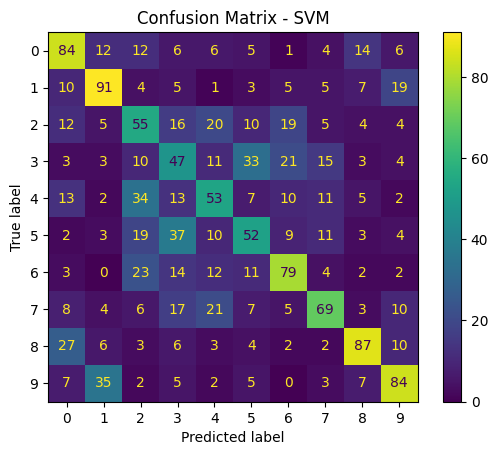

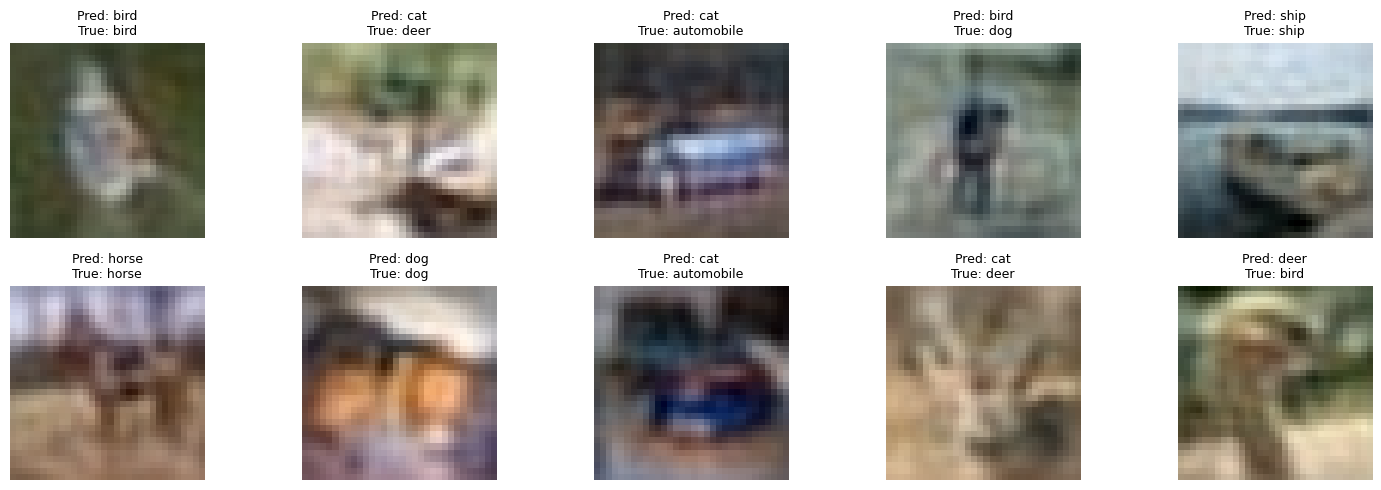


=== SECONDA FASE: MODEL SELECTION DOPO RIADDESTRAMENTO ===

Riaddestramento modello: Logistic Regression

Riaddestramento modello: k-NN
Iperparametri ottimali: {'metric': 'euclidean', 'n_neighbors': 5}

Riaddestramento modello: SVM


KeyboardInterrupt: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

# 1. Caricamento del dataset CIFAR-10
cifar10 = fetch_openml('cifar_10', version=1, as_frame=False)
X = cifar10.data.astype('float32')
y = cifar10.target.astype('int')

# 2. Sottocampionamento
X_subsample, _, y_subsample, _ = train_test_split(X, y, train_size=10000, stratify=y, random_state=42)

# 3. Divisione in train, val e test
X_train, X_temp, y_train, y_temp = train_test_split(X_subsample, y_subsample, train_size=0.7, stratify=y_subsample, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 4. Training completo
X_trainval_full = np.concatenate([X_train, X_val])
y_trainval_full = np.concatenate([y_train, y_val])

# 5. Standardizzazione
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

# 6. PCA
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca = pca.transform(X_val_std)
X_test_pca = pca.transform(X_test_std)
X_trainval_pca = pca.transform(scaler.transform(X_trainval_full))

# 7. Definizione modelli
models = {
    "Logistic Regression": (LogisticRegression(max_iter=5000, solver='liblinear', C=1.0), None),
    "k-NN": (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7], 'metric': ['euclidean', 'manhattan']}),
    "SVM": (SVC(), {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
    "Decision Tree": (DecisionTreeClassifier(), {'max_depth': [3, 5, None], 'min_samples_split': [2, 5], 'criterion': ['entropy']})
}

results = {}

# 8. Training e valutazione
print("=== PRIMA FASE: MODEL SELECTION SU VALIDATION SET ===")
for name, (model, param_grid) in models.items():
    print(f"\n==> Addestramento: {name}")
    
    if param_grid:
        grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_train_pca, y_train)
        best_model = grid.best_estimator_
        print(f"Iperparametri ottimali: {grid.best_params_}")
    else:
        model.fit(X_train_pca, y_train)
        best_model = model

    y_val_pred = best_model.predict(X_val_pca)
    results[name] = {
        "model": best_model,
        "accuracy": accuracy_score(y_val, y_val_pred),
        "precision": precision_score(y_val, y_val_pred, average='macro'),
        "recall": recall_score(y_val, y_val_pred, average='macro'),
        "f1": f1_score(y_val, y_val_pred, average='macro'),
        "confusion_matrix": confusion_matrix(y_val, y_val_pred),
        "report": classification_report(y_val, y_val_pred, output_dict=True)
    }

# 9. Tabella metriche
print("\n=== METRICHE SUL VALIDATION SET ===")
print("{:<20s} {:<10s} {:<10s} {:<10s} {:<10s}".format("Modello", "Accuracy", "Precision", "Recall", "F1"))
for name, res in results.items():
    print("{:<20s} {:.4f}     {:.4f}     {:.4f}   {:.4f}".format(name, res['accuracy'], res['precision'], res['recall'], res['f1']))

# 10. Miglior modello
best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_model = results[best_model_name]['model']
print(f"\n✅ Miglior modello su validation set: {best_model_name}")

# 11. Riaddestramento sul train+val
best_model.fit(X_trainval_pca, y_trainval_full)
y_test_pred = best_model.predict(X_test_pca)

# 12. Valutazione su test set
print(f"\n=== VALUTAZIONE DEL MODELLO {best_model_name} SU TEST SET ===")
print(classification_report(y_test, y_test_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

# 13. Visualizzazione immagini predette
label_map = {
    0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
    5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"
}

def show_predictions_reconstructed(model, X_pca, X_raw_std, y_true, label_map, scaler, pca, num_images=10):
    y_pred = model.predict(X_pca[:num_images])
    X_reconstructed = scaler.inverse_transform(pca.inverse_transform(X_pca[:num_images]))

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        img = X_reconstructed[i].reshape(3, 32, 32).transpose(1, 2, 0)
        img = np.clip(img, 0, 255).astype('uint8')
        true_lbl = label_map[y_true[i]]
        pred_lbl = label_map[y_pred[i]]
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {pred_lbl}\nTrue: {true_lbl}", fontsize=9)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_predictions_reconstructed(best_model, X_test_pca, X_test_std, y_test, label_map, scaler, pca)

# 14. Riaddestramento di tutti i modelli
print("\n=== SECONDA FASE: MODEL SELECTION DOPO RIADDESTRAMENTO ===")
all_results = {}
for name, (model, param_grid) in models.items():
    print(f"\nRiaddestramento modello: {name}")
    
    if param_grid:
        grid = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid.fit(X_trainval_pca, y_trainval_full)
        best_model_all = grid.best_estimator_
        print(f"Iperparametri ottimali: {grid.best_params_}")
    else:
        model.fit(X_trainval_pca, y_trainval_full)
        best_model_all = model

    y_test_pred = best_model_all.predict(X_test_pca)
    all_results[name] = {
        "model": best_model_all,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred, average='macro'),
        "recall": recall_score(y_test, y_test_pred, average='macro'),
        "f1": f1_score(y_test, y_test_pred, average='macro'),
        "confusion_matrix": confusion_matrix(y_test, y_test_pred),
        "report": classification_report(y_test, y_test_pred, output_dict=True)
    }

# 15. Tabella finale
print("\n=== METRICHE SU TEST SET (DOPO RIADDESTRAMENTO COMPLETO) ===")
print("{:<20s} {:<10s} {:<10s} {:<10s} {:<10s}".format("Modello", "Accuracy", "Precision", "Recall", "F1"))
for name, res in all_results.items():
    print("{:<20s} {:.4f}     {:.4f}     {:.4f}   {:.4f}".format(name, res['accuracy'], res['precision'], res['recall'], res['f1']))

final_best_name = max(all_results, key=lambda x: all_results[x]['accuracy'])
print(f"\n✅ Miglior modello finale dopo riaddestramento: {final_best_name}")
ConfusionMatrixDisplay.from_predictions(y_test, all_results[final_best_name]['model'].predict(X_test_pca))
plt.title(f"Confusion Matrix - {final_best_name}")
plt.show()
show_predictions_reconstructed(all_results[final_best_name]['model'], X_test_pca, X_test_std, y_test, label_map, scaler, pca)

# 16. Confronto finale
if best_model_name == final_best_name:
    print("\n📌 Il miglior modello è lo stesso in entrambi i metodi.")
else:
    print("\n📌 I modelli migliori trovati sono diversi tra i due metodi.")
